In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math


### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [42]:
# # Сигнатура функции и пример вывода:

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)
get_geodesic_distance(mipt,kremlin) # output = 20.676951995783696

20.679548379647574

In [41]:
def get_geodesic_distance(coord1, coord2):
    R = 6371800  # Earth radius in meters
    lat1, lon1 = coord1.x, coord1.y
    lat2, lon2 = coord2.x,coord2.y
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/1000

### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [3]:
big_moscow_districts = gpd.read_file('big_moscow_districts.shp')

<AxesSubplot:>

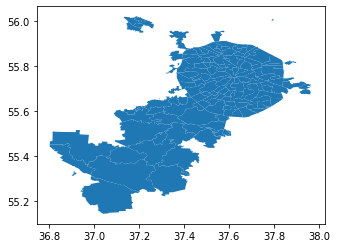

In [4]:
big_moscow_districts.plot()

In [5]:
from shapely.ops import nearest_points

def _get_nn_by_centroid(origin, neighbours):
    result = []
    c = origin.centroid
    for i, n in enumerate(neighbours):
        nc = n.centroid
        result.append((nc.distance(c), i))
    result.sort()
#     print(result[:10])
    return result

def _get_nn_by_board(origin, neighbours):
    result = []
    b = origin.boundary
    for i, n in enumerate(neighbours):
        bn = n.boundary
        p1, p2 = nearest_points(b, bn)
        result.append((p1.distance(p2), i))
    result.sort()
#     print(result[:10])
    return result

def get_k_nearest_neighbours_by_dist(origin, neighbours, k=10, kind='by_centroid'):
    neighbours = [n for n in neighbours if not n.almost_equals(origin)]
    if kind == 'by_centroid':
        r = _get_nn_by_centroid(origin, neighbours)
    else:
        r = _get_nn_by_board(origin, neighbours)
    r = r[:k]
    return gpd.GeoDataFrame({
        'dist': [v[0] for v in r],
        'geometry': [neighbours[v[1]] for v in r]
    })

In [6]:
# Сигнатура функции и пример вывода:
import random

polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid;

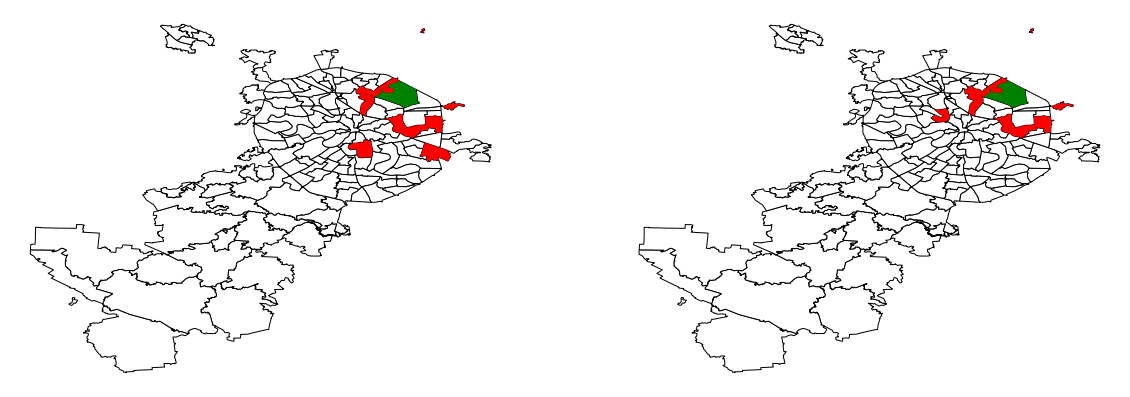

In [7]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
plt.title('Neighbours by centroid')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
plt.title('Neighbours by board')
ax.set_axis_off()

### Упражнение 3
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

In [8]:
# Сигнатура функции и пример вывода:

grid_big_moscow = gpd.read_file('grid_big_moscow.shp')
grid_big_moscow.set_crs("EPSG:4326")  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

In [72]:
def resolve_pair(ii, kind):
    ii = ii.copy()
    ii['factor'] = ii.area
    ii.factor /= ii.area.sum()
    if kind == 'prop':
        return [
            (row.aggi, row.factor)
            for row in ii.itertuples()
        ]
    else:
        row = ii.loc[ii.factor == ii.factor.max()].iloc[0]
        return [(row.aggi, 1.0)]

def spatial_resample(agg_polygons, init_polygons, method, column, kind):
    agg_polygons = agg_polygons.copy()
    init_polygons = init_polygons.copy()
    agg_polygons['aggi'] = np.arange(agg_polygons.shape[0])
    init_polygons['initi'] = np.arange(init_polygons.shape[0])
    intersections = gpd.overlay(agg_polygons, init_polygons, how='intersection')
    values = np.zeros((agg_polygons.shape[0], 2), dtype=float)
    for i in range(init_polygons.shape[0]):
        ii = intersections[intersections.initi == i]
        if not ii.shape[0]:
            continue
        ais = resolve_pair(ii, kind)
        iv = init_polygons.iloc[i][column]
        for ai, factor in ais:
            val = iv * factor
            values[ai, 0] += val
            values[ai, 1] += 1
    agg_polygons[column] = [
        row[0] if method == 'sum' else row[0] / row[1]
        for row in values
    ]
    return agg_polygons.drop(columns=['aggi'])

In [71]:
mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
mean_resample_table.head()

,geometry,random_value
0,"POLYGON ((37.68525 55.89508, 37.68891 55.89504...",39.629630
1,"POLYGON ((37.60716 55.87932, 37.60754 55.87911...",54.461538
2,"POLYGON ((37.64437 55.89768, 37.65226 55.89678...",41.192308
3,"POLYGON ((37.49625 55.89248, 37.49851 55.89347...",44.741935
4,"POLYGON ((37.41143 55.87096, 37.40632 55.87426...",50.851064


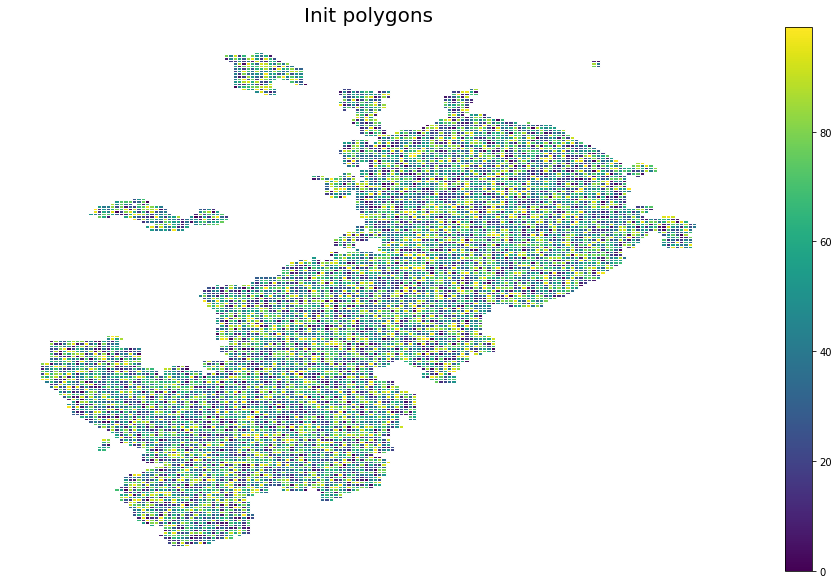

In [42]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

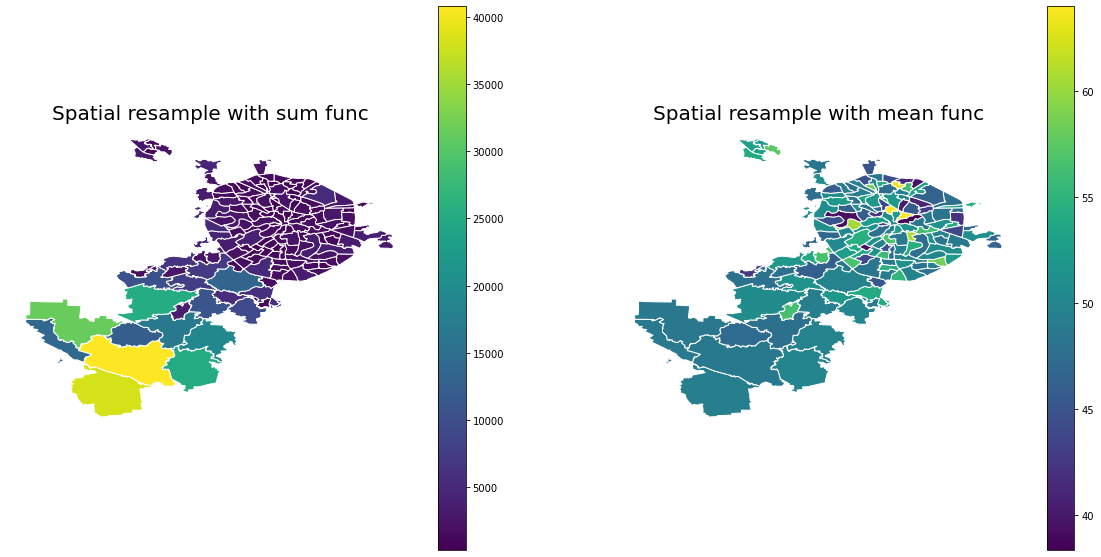

In [73]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`